In [1]:
from typing import List

import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax import grad, value_and_grad
import matplotlib.pylab as plt

import tidy3d as td
from tidy3d.plugins import ModeSolver

from tidy3d.plugins.adjoint.components import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

INFO:rich:Using client version: 1.8.0


In [18]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.05

# space between boxes and PML
buffer = 1.5 * wavelength

# optimize region size
lz = 0.5
lx, ly = 7.0, 5.0
wg_width = .7

# num cells
nx, ny = (7, 5)
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx/2 - buffer * 0.8
meas_x = lx/2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer

# permittivity info
eps_wg = 2.75
eps_deviation_random = 0.5

eps_mid = (1 + eps_wg) / 2
eps_boxes = eps_mid * np.ones((nx, ny))
eps_boxes += 2 * (np.random.random((nx, ny)) - 0.5) * eps_deviation_random
eps_boxes = eps_boxes.flatten().tolist()

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# mode in and out
mode_index_in = 1
mode_index_out = 2
num_modes = max(mode_index_in, mode_index_out) + 1
mode_spec = td.ModeSpec(num_modes=num_modes)

In [19]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz)),
    medium=td.Medium(permittivity=eps_wg)
)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+"
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)

In [20]:
def make_input_structures(*eps_boxes) -> List[JaxStructure]:
    
    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)
    
    x0_min = -lx/2 + size_box_x/2
    y0_min = -ly/2 + size_box_y/2
    
    input_structures = []

    index_box = 0
    for index_x in range(nx):
        x0 = x0_min + index_x * size_box_x - 1e-5
        for index_y in range(ny):
            y0 = y0_min + index_y * size_box_y - 1e-5
            eps_box = eps_boxes[index_box]
            medium = JaxMedium(permittivity=eps_box)
            geometry = JaxBox(center=(x0, y0, 0), size=size_box)
            structure = JaxStructure(geometry=geometry, medium=medium)
            input_structures.append(structure)
            index_box += 1
    return input_structures

In [21]:
def make_sim(*eps_boxes) -> JaxSimulation:
    
    input_structures = make_input_structures(*eps_boxes)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=False,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

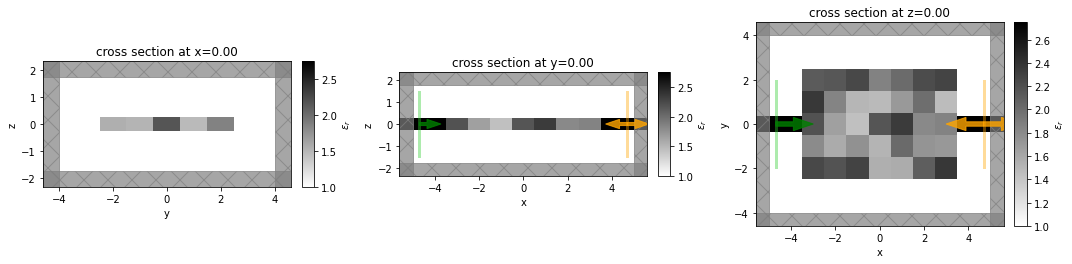

In [22]:
sim_start = make_sim(*eps_boxes)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(15, 10))

for dim, ax in zip('xyz', axes):
    sim_start.to_simulation()[0].plot_eps(**{dim:0}, ax=ax)

plt.show()

Effective index of computed modes:  [[1.4074442 1.3673046 1.1052969]]


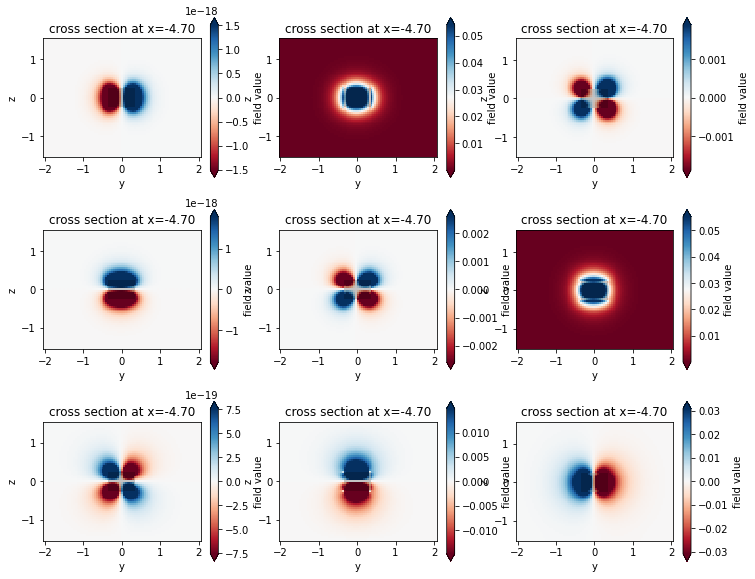

In [23]:
mode_solver = ModeSolver(simulation=sim_start, plane=forward_source, mode_spec=mode_spec, freqs=[freq0])
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(12, 10))
for mode_ind in range(num_modes):
    mode_solver.plot_field("Ex", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    mode_solver.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
    mode_solver.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 2])

In [24]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp)**2)

In [25]:
def J(*eps_boxes, step_num:int=None) -> float:
    sim = make_sim(*eps_boxes)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name)
    power = measure_power(sim_data)
    return power

In [26]:
dJ_fn = value_and_grad(J, argnums=tuple(range(num_cells)))

In [ ]:
# power, grad_eps = dJ_fn(*eps_boxes)
# grad_scaled = np.array(grad_eps).copy() * (dl / k0)**3
# print(f"measured power = {power:.2e}")
# print(f"norm of gradient = {np.linalg.norm(grad_scaled):.2e}")

In [27]:
step_size = 0.3
num_steps = 6

td.config.logging_level = "warning"

Js = []

def step(eps_boxes: np.ndarray, step_num:int=None) -> np.ndarray:
    eps_boxes_list = eps_boxes.tolist()
    power, grad_eps = dJ_fn(*eps_boxes_list, step_num=step_num)
    print(f"\tpower = {power:.4e}")
    Js.append(power)
    grad_scaled = np.array(grad_eps).copy() * (dl / k0)**3
    print(f"\tnorm of gradient = {np.linalg.norm(grad_scaled):.4e}")
    eps_boxes_updated = eps_boxes.copy() + step_size * grad_scaled
    return eps_boxes_updated

eps_boxes_arr = np.array(eps_boxes)
for step_num in range(num_steps):
    print(f"at step {(step_num + 1)}:")
    eps_boxes_arr = step(eps_boxes_arr, step_num=step_num+1)


↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 97.9% • 13.1/13.4 MB • 5.1 MB/s • 0:00:01

	power = 5.6485e-02
	norm of gradient = 1.7137e-01


In [29]:
for step_num in range(num_steps, 3*num_steps):
    print(f"at step {(step_num + 1)}:")
    eps_boxes_arr = step(eps_boxes_arr, step_num=step_num+1)


↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 97.9% • 13.1/13.4 MB • 3.3 MB/s • 0:00:01

	power = 1.2417e-01
	norm of gradient = 1.3706e-01


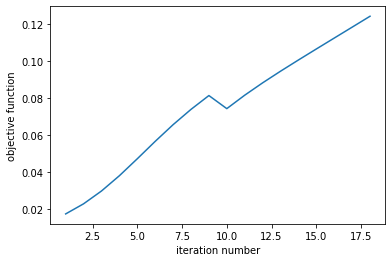

In [30]:
plt.plot(range(1, len(Js) + 1), Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.yscale('linear')
plt.show()

In [31]:
sim = make_sim(*eps_boxes_arr.tolist())

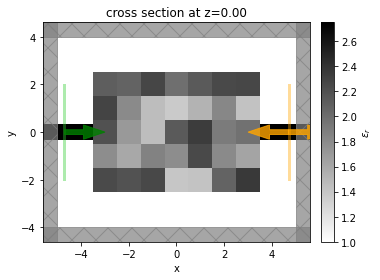

In [33]:
sim.to_simulation()[0].plot_eps(z=0)